# Intro

Welcome to the interactive 'classification by drawing' notebook!
This notebook goes through each step and allows you to tune parameters and view how it changes the results.

The notebook proceeds as follows:

1. **Import** libraries
2. Define **paths** to data
3. Run data through the **pipeline**. (ROInet embedding + UMAP)
4. **Draw** a circle around a region of the UMAP embedding to select as 'good ROIs to keep'
5. **Visualize** results
6. **Save** results


##### If running on google colab:

- install roicat

After running the cell below, the runtime will restart.

In [2]:
#@title Install `roicat` if on colab
using_colab = 'google.colab' in str(get_ipython())

if using_colab:
    !pip uninstall -y tensorflow
    !pip install roicat[classification]

- mount google drive

In [3]:
#@title mount gdrive if on colab
#@markdown Upload your data to Google Drive, then mount the drive and access the cloud directory here.
#@markdown You can use the sidebar to the left to browse your google drive directories.

using_colab = 'google.colab' in str(get_ipython())

if using_colab:
    from google.colab import drive
    path_gdrive = '/content/gdrive'
    drive.mount(path_gdrive, force_remount=True)

- enable widgets

In [4]:
if using_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

# Import libraries

Widen the notebook

In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

Import basic libraries

In [2]:
from pathlib import Path
import tempfile

import numpy as np
from umap import UMAP

Import `roicat`

In [3]:
import roicat

In [4]:
# Import vrAnalysis related code
from vrAnalysis import database
from vrAnalysis.helpers import smart_pca

# Find paths to data

##### Prepare list of paths to data

In this example we are using suite2p output files, but other data types can be used (CaImAn, etc.) \
See the notebook on ingesting diverse data: https://github.com/RichieHakim/ROICaT/blob/main/notebooks/jupyter/other/demo_custom_data_importing.ipynb

Make a list containing the paths to all the input files.

In this example we are using suite2p, so the following are defined:
1. `paths_allStat`: a list to all the stat.npy files
2. `paths_allOps`: a list with ops.npy files that correspond 1-to-1 with the stat.npy files

In [14]:
# Create link to vrDatabase containing all data and get session paths for target mouse
mouseName = "ATL027"
vrdb = database.vrDatabase('vrSessions')
ises = vrdb.iterSessions(imaging=True, mouseName=mouseName, dontTrack=False)
pathList = []
for ses in ises:
    pathList.append(ses.sessionPath())
for idx, pl in enumerate(pathList): print(idx, pl)

0 C:\Users\andrew\Documents\localData\ATL027\2023-07-19\701
1 C:\Users\andrew\Documents\localData\ATL027\2023-07-20\701
2 C:\Users\andrew\Documents\localData\ATL027\2023-07-21\701
3 C:\Users\andrew\Documents\localData\ATL027\2023-07-24\701
4 C:\Users\andrew\Documents\localData\ATL027\2023-07-25\701
5 C:\Users\andrew\Documents\localData\ATL027\2023-07-26\701
6 C:\Users\andrew\Documents\localData\ATL027\2023-07-27\701
7 C:\Users\andrew\Documents\localData\ATL027\2023-07-28\701
8 C:\Users\andrew\Documents\localData\ATL027\2023-08-01\701
9 C:\Users\andrew\Documents\localData\ATL027\2023-08-02\701
10 C:\Users\andrew\Documents\localData\ATL027\2023-08-04\702
11 C:\Users\andrew\Documents\localData\ATL027\2023-08-07\701
12 C:\Users\andrew\Documents\localData\ATL027\2023-08-08\701
13 C:\Users\andrew\Documents\localData\ATL027\2023-08-09\701


In [6]:
dir_allOuterFolders = pathList[10] #r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/stat_and_ops'

pathSuffixToStat = 'stat.npy'
pathSuffixToOps = 'ops.npy'

paths_allStat = roicat.helpers.find_paths(
    dir_outer=dir_allOuterFolders,
    reMatch=pathSuffixToStat,
    depth=6,
)[:]
paths_allOps  = np.array([Path(path).resolve().parent / pathSuffixToOps for path in paths_allStat])[:]

print(f'paths to all stat files:');
[print(path) for path in paths_allStat];
print('');
print(f'paths to all ops files:');
[print(path) for path in paths_allOps];

paths to all stat files:
C:\Users\andrew\Documents\localData\ATL022\2023-04-19\701\suite2p\plane0\stat.npy
C:\Users\andrew\Documents\localData\ATL022\2023-04-19\701\suite2p\plane1\stat.npy
C:\Users\andrew\Documents\localData\ATL022\2023-04-19\701\suite2p\plane2\stat.npy
C:\Users\andrew\Documents\localData\ATL022\2023-04-19\701\suite2p\plane3\stat.npy
C:\Users\andrew\Documents\localData\ATL022\2023-04-19\701\suite2p\plane4\stat.npy

paths to all ops files:
C:\Users\Andrew\Documents\localData\ATL022\2023-04-19\701\suite2p\plane0\ops.npy
C:\Users\Andrew\Documents\localData\ATL022\2023-04-19\701\suite2p\plane1\ops.npy
C:\Users\Andrew\Documents\localData\ATL022\2023-04-19\701\suite2p\plane2\ops.npy
C:\Users\Andrew\Documents\localData\ATL022\2023-04-19\701\suite2p\plane3\ops.npy
C:\Users\Andrew\Documents\localData\ATL022\2023-04-19\701\suite2p\plane4\ops.npy


**Important parameters**:

- `um_per_pixel` (float):
    - Resolution. 'micrometers per pixel' of the imaging field of view.

In [8]:
data = roicat.data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    um_per_pixel=1.6,  
    new_or_old_suite2p='new',
    type_meanImg='meanImgE',
    verbose=True,
)

assert data.check_completeness(verbose=False)['classification_inference'], f"Data object is missing attributes necessary for tracking."

c:\users\andrew\documents\github\roicat\roicat\util.py:416: UserWarning: RH WARNING: unable to get gcc version. Got error: [WinError 2] The system cannot find the file specified
  warnings.warn(f'RH WARNING: unable to get gcc version. Got error: {e}')


Starting: Importing FOV images from ops files
Completed: Set FOV_height and FOV_width successfully.
Completed: Imported 5 FOV images.
Setting FOV_images...
Completed: Set FOV_images for 5 sessions successfully.
Importing spatial footprints from stat files.


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Imported 5 sessions of spatial footprints into sparse arrays.
Completed: Set spatialFootprints for 5 sessions successfully.
Completed: Created session_bool.
Completed: Created centroids.
Starting: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.


# ROInet embedding

This step passes the images of each ROI through the ROInet neural network. The inputs are the images, the output is an array describing the visual properties of each ROI.

##### 1. Initialize ROInet

Initialize the ROInet object. The `ROInet_embedder` class will automatically download and load a pretrained ROInet model. If you have a GPU, this step will be much faster.

In [9]:
DEVICE = roicat.helpers.set_device(use_GPU=True, verbose=True)
dir_temp = tempfile.gettempdir()

roinet = roicat.ROInet.ROInet_embedder(
    device=DEVICE,  ## Which torch device to use ('cpu', 'cuda', etc.)
    dir_networkFiles=dir_temp,  ## Directory to download the pretrained network to
    download_method='check_local_first',  ## Check to see if a model has already been downloaded to the location (will skip if hash matches)
    download_url='https://osf.io/c8m3b/download',  ## URL of the model
    download_hash='357a8d9b630ec79f3e015d0056a4c2d5',  ## Hash of the model file
    forward_pass_version='head',  ## How the data is passed through the network
    verbose=True,  ## Whether to print updates
)

roinet.generate_dataloader(
    ROI_images=data.ROI_images,  ## Input images of ROIs
    um_per_pixel=data.um_per_pixel,  ## Resolution of FOV
    pref_plot=False,  ## Whether or not to plot the ROI sizes
);
images = roinet.ROI_images_rs

Using device: cuda:0


c:\users\andrew\documents\github\roicat\roicat\util.py:416: UserWarning: RH WARNING: unable to get gcc version. Got error: [WinError 2] The system cannot find the file specified
  warnings.warn(f'RH WARNING: unable to get gcc version. Got error: {e}')


File already exists locally: C:\Users\Andrew\AppData\Local\Temp\ROInet.zip
Hash of local file matches provided hash_hex.
Extracting C:\Users\Andrew\AppData\Local\Temp\ROInet.zip to C:\Users\Andrew\AppData\Local\Temp.
Completed zip extraction.
Imported model from C:\Users\Andrew\AppData\Local\Temp\ROInet_classification_20220902\model.py
Loaded params_model from C:\Users\Andrew\AppData\Local\Temp\ROInet_classification_20220902\params.json


C:\Users\Andrew\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Andrew\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from C:\Users\Andrew\AppData\Local\Temp\ROInet_classification_20220902\ConvNext_tiny__1_0_unfrozen__simCLR.pth
Loaded network onto device cuda:0
Starting Image Resizer
Creating dataloader
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader


##### 2. Check ROI_images sizes
In general, you want to see that a neuron fills roughly 25-50% of the area of the image. \
**Adjust `um_per_pixel` above to rescale image size**


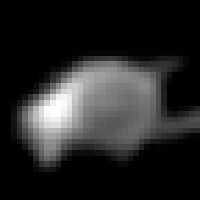

In [10]:
roicat.visualization.display_toggle_image_stack(images[:1000], image_size=(200,200))

##### 3. Pass data through network

Pass the data through the network. Expect for large datasets (~40,000 ROIs) that this takes around 15 minutes on CPU or 1 minute on GPU.

In [11]:
roinet.generate_latents();

starting: running data through network


  0%|          | 0/2157 [00:01<?, ?it/s]

completed: running data through network


In [13]:
roinet.latents.shape

torch.Size([17250, 128])

In [12]:
dir_allOuterFolders

WindowsPath('C:/Users/andrew/Documents/localData/ATL022/2023-04-19/701')

# UMAP embedding

Reduce the dimensionality of the output of ROInet (~100 dims) to 2 dimensions so that we can visualize it. Feel free to use any settings here that do a good job of clustering your data as you see fit.

In [50]:
model_umap = UMAP(
    n_neighbors=25,
    n_components=2,
    n_epochs=400,
    verbose=True,
    densmap=False,
)
emb = model_umap.fit_transform(roinet.latents)

UMAP(n_epochs=400, n_neighbors=25, verbose=True)
Thu Dec 12 13:22:52 2024 Construct fuzzy simplicial set
Thu Dec 12 13:22:52 2024 Finding Nearest Neighbors
Thu Dec 12 13:22:52 2024 Building RP forest with 12 trees
Thu Dec 12 13:22:52 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Thu Dec 12 13:22:52 2024 Finished Nearest Neighbor Search
Thu Dec 12 13:22:52 2024 Construct embedding


Epochs completed:   0%|            0/400 [00:00]

	completed  0  /  400 epochs
	completed  40  /  400 epochs
	completed  80  /  400 epochs
	completed  120  /  400 epochs
	completed  160  /  400 epochs
	completed  200  /  400 epochs
	completed  240  /  400 epochs
	completed  280  /  400 epochs
	completed  320  /  400 epochs
	completed  360  /  400 epochs
Thu Dec 12 13:22:54 2024 Finished embedding


# Draw selection

In order to visualize the kinds of ROIs at each region of the plot, we need to select a subset of points to overlay ROI images onto.

In [51]:
idx_images_overlay = roicat.visualization.get_spread_out_points(
    emb,
    n_ims=min(emb.shape[0], 1500),  ## Select number of overlayed images here
    dist_im_to_point=0.8,
#     border_frac=0.05,
)

images_overlay = images[idx_images_overlay]

Now we can use an interactive plot (using the holoviews library) to select our region of the scatterplot to circle.\
This plot works as follows:
- Use the **LASSO TOOL** to circle a region on the plot containing the images of ROIs that you'd like to keep/extract/mark.
    - You can circle multiple times, but only the last one will be saved
- The saved indices are saved in a temporary file that can be recovered using the `fn_get_indices` function output below. Just call `fn_get_indices()` and it will return a list of the integer indices.
- If it is difficult to see the images, do the following:
    - adjust the number of images in the above function (`roicat.visualization.get_spread_out_points`) using the `n_ims` argument
    - adjust the overlap of the images in the below function (`roicat.visualization.select_region_scatterPlot`) using the `frac_overlap_allowed` argument

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
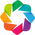

BokehModel(combine_events=True, render_bundle={'docs_json': {'38fea40c-0948-432f-829d-d66b4acbffa0': {'version…

Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh
Callback from bokeh


In [53]:
fn_get_indices, layout, path_tempFile = roicat.visualization.select_region_scatterPlot(
    data=emb,
    idx_images_overlay=idx_images_overlay,
    images_overlay=images_overlay[:, 6:30][:,:,6:30],
    size_images_overlay=0.25,
    frac_overlap_allowed=0.25,
    figsize=(800, 800),
    alpha_points=1.0,
    size_points=3,
    color_points='b',
)

Drop the results into easier to use output variables

In [39]:
## Save the layout to an SVG file if desired
# roicat.helpers.export_svg_hv_bokeh(layout, '/home/rich/Desktop/umap_with_labels_dotsOnly.svg')

In [58]:
n_sessions = len(data.ROI_images)
idx_session_cat = np.concatenate([[ii]*data.ROI_images[ii].shape[0] for ii in range(n_sessions)])
bool_good_cat = roicat.helpers.idx2bool(fn_get_indices(), length=len(idx_session_cat))
preds_good_sessions = roicat.util.JSON_List([[int(l) for l in labels] for labels in roicat.util.labels_to_labelsBySession(bool_good_cat, data.n_roi)])

run_data = {
    "data": data.__dict__,
    "roinet": roinet.__dict__,
    "umap_embedding": emb,
    "preds": preds_good_sessions,
}

# Visualize outputs

In [59]:
print(f"Number of 'good' and 'bad' ROIs from each session:")
print([f"good: {np.array(p).sum()} / bad: {(np.array(p)!=1).sum()}" for p in preds_good_sessions])

Number of 'good' and 'bad' ROIs from each session:
['good: 690 / bad: 2771', 'good: 467 / bad: 2962', 'good: 355 / bad: 3118', 'good: 726 / bad: 2754', 'good: 1179 / bad: 2228']



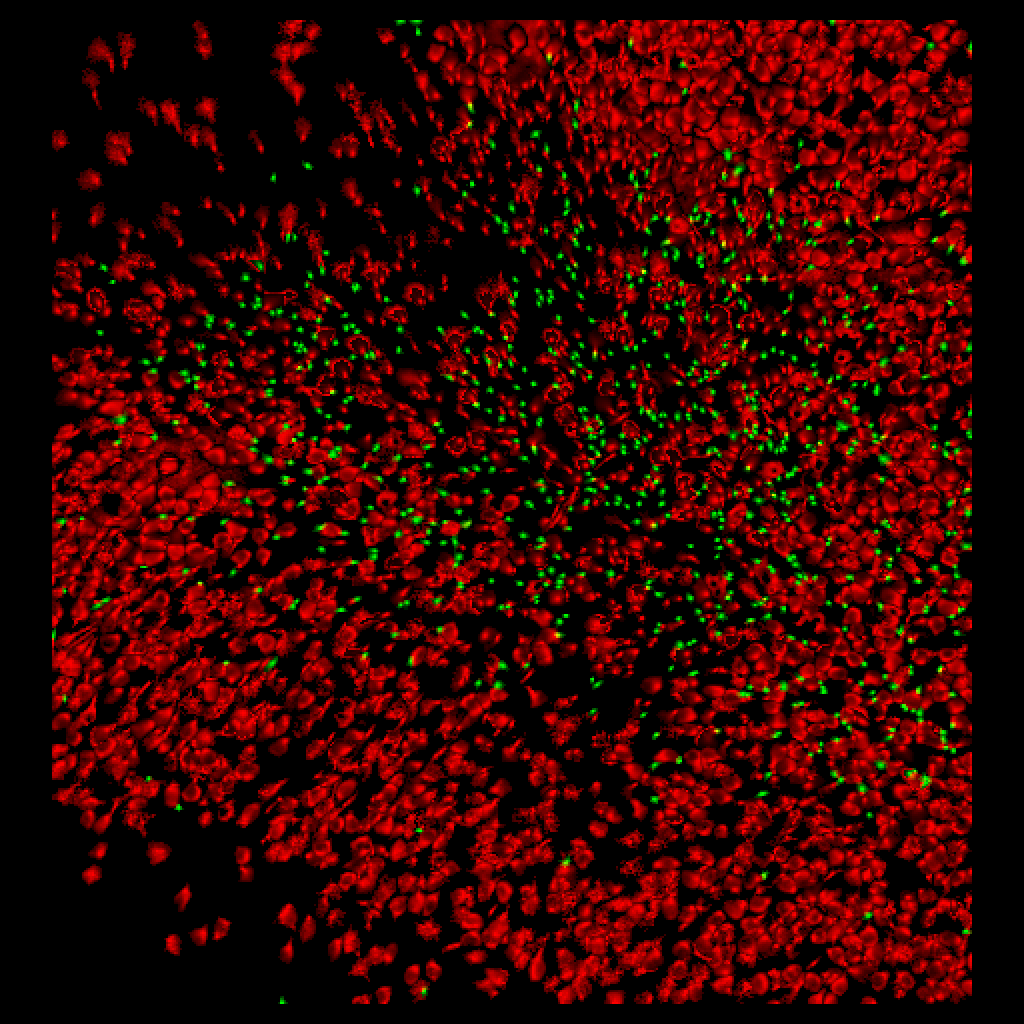

In [60]:
FOVs_colored = roicat.visualization.compute_colored_FOV(
    spatialFootprints=data.spatialFootprints,
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    labels=preds_good_sessions,
    cmap=roicat.helpers.simple_cmap([[1,0,0],[0,1,0]]),
)

roicat.visualization.display_toggle_image_stack(
    FOVs_colored,
    image_size=(FOVs_colored[0].shape[0]*2, FOVs_colored[0].shape[1]*2)
)

# Save results

The results file can be opened using any of the following methods:
1. `roicat.helpers.pickle_load(path)`
2. `np.load(path)`
3. 
```
    import pickle
    with open(path_save, mode='rb') as f:
        test = pickle.load(f)
  ```

In [61]:
# Save the results in the directory they came from
label="dendrites"
paths_save = [Path(path).resolve().parent / f'roicat_test_label_{label}.npy' for path in paths_allStat]
for pth, labels in zip(paths_save, preds_good_sessions):
    print(pth)
    np.save(pth, np.array(labels))

C:\Users\Andrew\Documents\localData\ATL022\2023-04-19\701\suite2p\plane0\roicat_test_label_dendrites.npy
C:\Users\Andrew\Documents\localData\ATL022\2023-04-19\701\suite2p\plane1\roicat_test_label_dendrites.npy
C:\Users\Andrew\Documents\localData\ATL022\2023-04-19\701\suite2p\plane2\roicat_test_label_dendrites.npy
C:\Users\Andrew\Documents\localData\ATL022\2023-04-19\701\suite2p\plane3\roicat_test_label_dendrites.npy
C:\Users\Andrew\Documents\localData\ATL022\2023-04-19\701\suite2p\plane4\roicat_test_label_dendrites.npy


In [33]:
paths_save

[WindowsPath('C:/Users/Andrew/Documents/localData/ATL027/2023-08-04/702/suite2p/plane0/roicat_test_label_cells.json'),
 WindowsPath('C:/Users/Andrew/Documents/localData/ATL027/2023-08-04/702/suite2p/plane1/roicat_test_label_cells.json'),
 WindowsPath('C:/Users/Andrew/Documents/localData/ATL027/2023-08-04/702/suite2p/plane2/roicat_test_label_cells.json'),
 WindowsPath('C:/Users/Andrew/Documents/localData/ATL027/2023-08-04/702/suite2p/plane3/roicat_test_label_cells.json'),
 WindowsPath('C:/Users/Andrew/Documents/localData/ATL027/2023-08-04/702/suite2p/plane4/roicat_test_label_cells.json')]

In [ ]:
## Define the directory to save the results to
dir_save = '/media/rich/bigSSD/data_tmp/test_data/'
name_save = 'mouse_1'

paths_save = {
    'preds': str(Path(dir_save) / f'{name_save}.classification_drawn.preds.json'),
    'run_data': str(Path(dir_save) / f'{name_save}.classification_drawn.run_data.richfile'),
}

roicat.helpers.json_save(obj=preds_good_sessions, filepath=paths_save['preds'])
roicat.util.RichFile_ROICaT(path=paths_save['run_data']).save(run_data, overwrite=True)

# Thank you
If you encountered any difficulties, please let us know at the issues page: https://github.com/RichieHakim/ROICaT/issues